# FFT as Linear Operator

**Author: M. Ravasi, KAUST**

Welcome to the first exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to:

- Introduce the concept of *linear operator* and the difference with dense matrices in both computation time and memory load;
- Show how PyLops can be used to set-up linear operators and solve inverse problems in Python;

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pympler pyproximal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pympler
import pyproximal

from pylops import FirstDerivative, MatrixMult, Restriction, SecondDerivative
from pylops.signalprocessing import FFT
from pylops.optimization.leastsquares import regularized_inversion
from pylops.utils import dottest

from fft import *

## The Fourier Transform

The Fourier Transform is a powerful tool in signal processing to decompose a signal into a linear combination of complex sinusoids:

$$
X(f) = \int x(t) e^{-j 2 \pi f t} dt
$$

whose inverse is represented by 

$$
x(t) = \int X(f) e^{j 2 \pi f t} df
$$

In practice, this integral is discretized giving rise to the Discrete Fourier Transform (DFT):

$$
X_k = \frac{1}{\sqrt{N}}\sum_{n=0}^{N-1} x_n e^{-j 2 \pi \frac{k}{N} n}
$$

and its inverse:

$$
x_n = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} X_k e^{j 2 \pi \frac{k}{N} n}
$$

Note the presence of the $1/\sqrt{N}$ factor in front of both the forward and inverse DFT. This is to allow symmetry between the two operations and ensure that the inverse is also the adjoint. We will come back to this point later.

Let's now put what we have learned into practice.



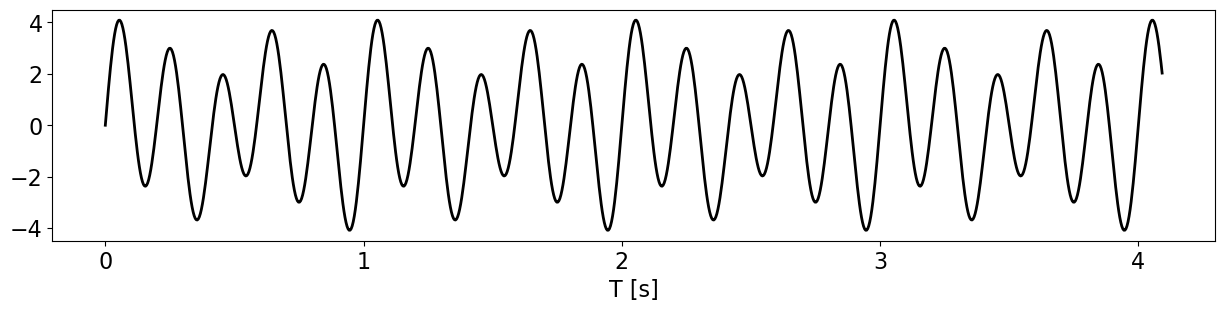

In [3]:
# Time axis
dt = 0.004 # time sampling (seconds)
nt = 1024 # number of time samples
t = np.arange(nt) * dt

# Frequencies and amplitudes
f0 = [2, 4, 5]
a = [1, 0.5, 3]

# Create signal
x = np.sum([a_* np.sin(2*np.pi*f_*t)for f_, a_ in zip (f0, a)], axis=0)

plt.figure(figsize=(15, 3))
plt.plot(t, x, 'k', lw=2)
plt.xlabel('T [s]')
plt.axis('tight');

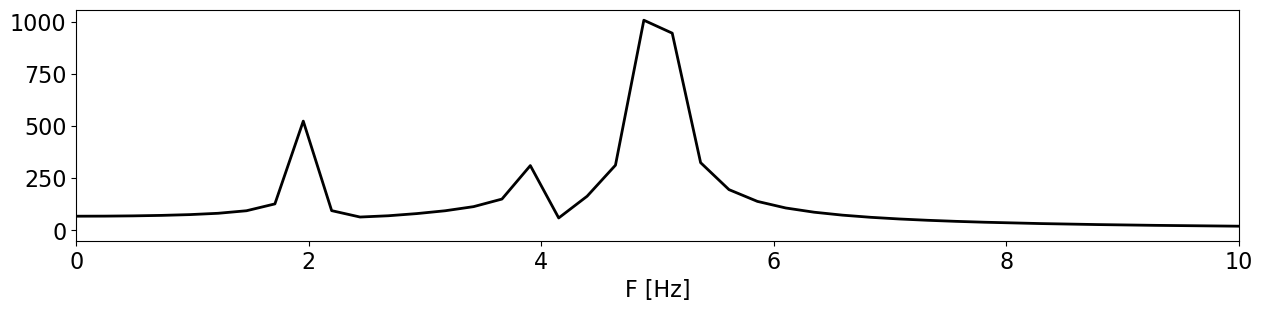

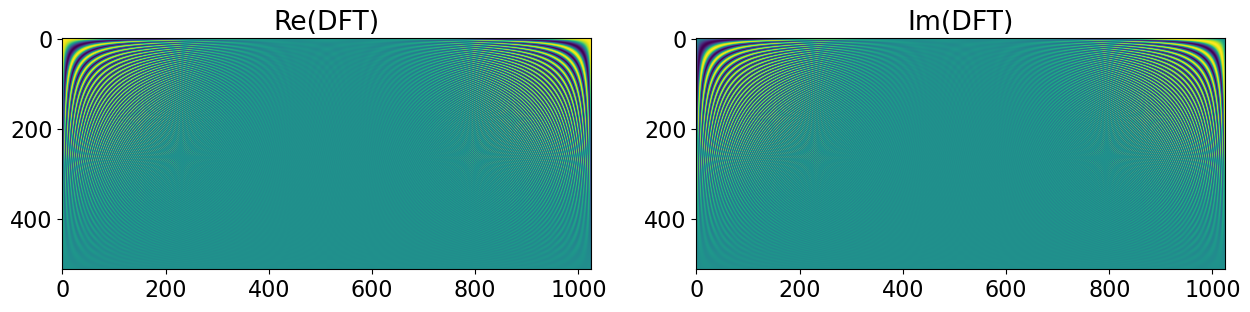

In [ ]:
# Compute DFT
X, D = DFT(x)
f = np.fft.rfftfreq(nt, dt)

plt.figure(figsize=(15, 3))
plt.plot(f[:nt//2], np.abs(X[:nt//2]), 'k', lw=2)
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 10);

fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].imshow(D.real)
axs[0].set_title('Re(DFT)')
axs[0].axis('tight')
axs[1].imshow(D.imag)
axs[1].set_title('Im(DFT)')
axs[1].axis('tight');

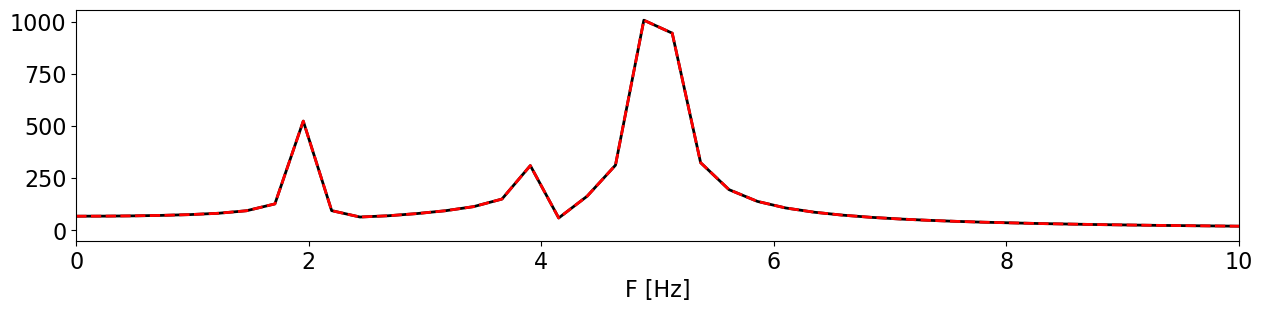

In [5]:
# Compute FFT
Xf = np.fft.rfft(x)

plt.figure(figsize=(15, 3))
plt.plot(f[:nt//2], np.abs(X[:nt//2]), 'k', lw=2, label='DFT')
plt.plot(f[:nt//2], np.abs(Xf[:nt//2]), '--r', lw=2, label='FFT')
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 10);

### Timings

In [6]:
def FFT_time(n):
    """Timing of of DFT/FFT operator
    """
    x = np.arange(n)
    _, D = DFT(x)
    Dop = FFT(n, engine='scipy', real=True)
    
    print('Timings for DFT, FFT-scipy, FFT-pylops(scipy)')
    %timeit -n 5 -r 2 np.dot(D, x)
    %timeit -n 5 -r 2 sp.fft.rfft(x)
    %timeit -n 5 -r 2 Dop.matvec(x)

In [7]:
nt_time = 2 **12
FFT_time(nt_time)

Timings for DFT, FFT-scipy, FFT-pylops(scipy)
1.76 ms ± 26.6 µs per loop (mean ± std. dev. of 2 runs, 5 loops each)
44.2 µs ± 23.9 µs per loop (mean ± std. dev. of 2 runs, 5 loops each)
49.8 µs ± 13.9 µs per loop (mean ± std. dev. of 2 runs, 5 loops each)


### Memory

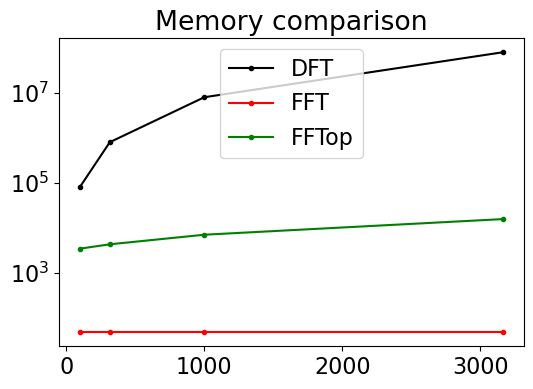

In [8]:
FFT_memory()

## The Fourier transform as Linear Operator

At this point, we know that we can create the Fourier operator in two different ways (and which one is best from both a computational and memory standpoint). 

But can we do the same with the inverse Fourier transform and create a linear operator that passes the dot-test?

In [9]:
# Again DFT
DCTop = MatrixMult(D / np.sqrt(nt//2 + 1), dtype=np.complex128)

dottest(DCTop, verb=True);

Dot test passed, v^H(Opu)=(-0.3793804902656692+5.6731225798076315j) - u^H(Op^Hv)=(-0.37938049026568255+5.673122579807682j)


In [10]:
# FFT
FFTop = FFT(nt, engine='scipy', real=True)
    
dottest(FFTop, complexflag=2, verb=True);

Dot test passed, v^H(Opu)=12.160180019972781 - u^H(Op^Hv)=12.160180019972778


In [11]:
Xd = DCTop @ x
Xf = FFTop @ x

xadjd = DCTop.H @ Xd
xadjf = FFTop.H @ Xf

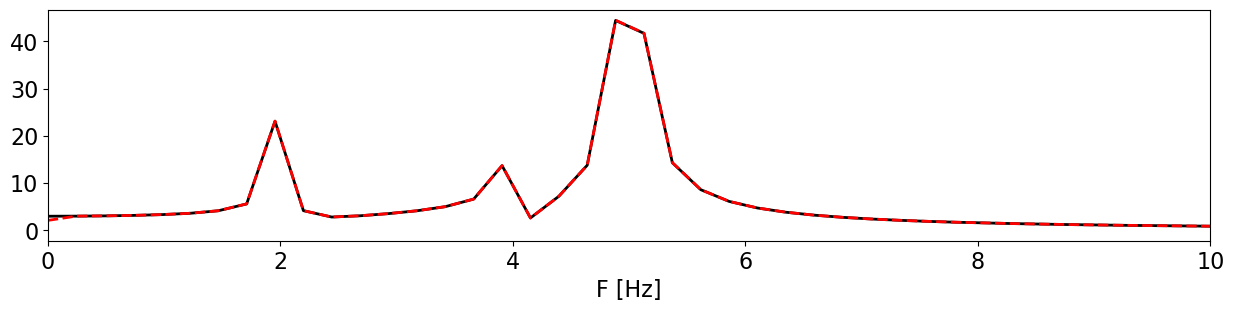

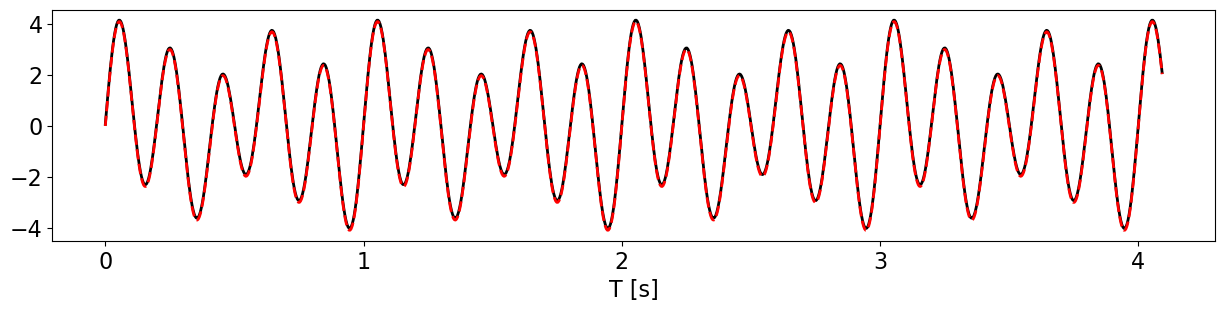

In [12]:
plt.figure(figsize=(15, 3))
plt.plot(f[:nt//2], np.abs(Xd[:nt//2]), 'k', lw=2, label='DFT')
plt.plot(f[:nt//2], np.abs(Xf[:nt//2]), '--r', lw=2, label='FFT')
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 10);

plt.figure(figsize=(15, 3))
plt.plot(t, xadjd.real, 'k', lw=2, label='DFT')
plt.plot(t, xadjf, '--r', lw=2, label='FFT')
plt.xlabel('T [s]')
plt.axis('tight');

As you can see, we have created two linear operators that do produce the exact same results, although implementing the FFT differently

## Subsampled Fourier transform

Finally, let's consider an example where we want to reconstruct a signal from a subsampled Fourier trasform:

$$
\mathbf{y} = \mathbf{RF}\mathbf{x}
$$

where $\mathbf{F}$ and $\mathbf{R}$ are the FFT and restriction operators, respectively. Note that, alternatively, one could use the Non-Uniform FFT (NUFFT) to perform both operations simultaneously.

The goal of this exercise is NOT to retrieve a good representation of the input signal from few Fourier coefficients (we will see that this is very difficult in 1D) but to get a feeling once again for how a linear operator can be used within a classical gradient-based iterative solver as well as within a proximal solver.

In [16]:
x = np.zeros(nt)
x[: nt // 2] = 10
x[nt // 2 : 3 * nt // 4] = -5

X = FFTop @ x

Fourier domain subsampling factor: 1.7


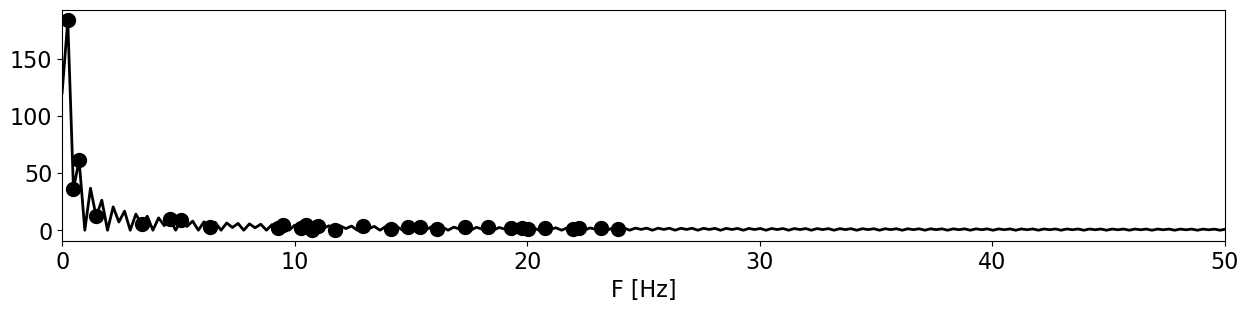

In [17]:
# Create subsampled Fourier domain
np.random.seed(10)

ntsub = 30
ifava = np.random.permutation(np.arange(nt//10))[:ntsub]
Rop = Restriction(nt//2+1, ifava, dtype=np.complex128)
y = Rop @ FFTop @ x

print('Fourier domain subsampling factor:', ((nt//20)/30))

plt.figure(figsize=(15, 3))
plt.plot(f, np.abs(X), 'k', lw=2)
plt.plot(f[ifava], np.abs(y), '.k', ms=20)
plt.xlabel('F [Hz]')
plt.axis('tight')
plt.xlim(0, 50);

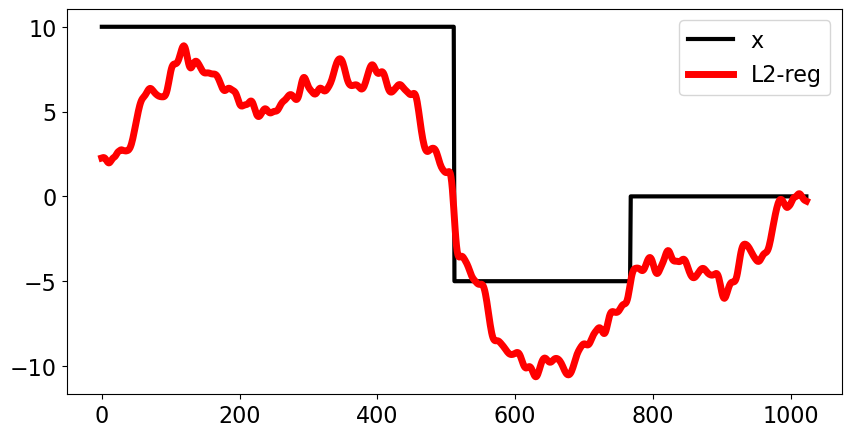

In [18]:
D2op = SecondDerivative(nt, edge=True, dtype=np.complex128)
alpha = 1e2

xinv = regularized_inversion(
    Rop @ FFTop, y, [D2op], epsRs=[np.sqrt(alpha / 2)], **dict(iter_lim=30))[0].real

#with plt.xkcd():
plt.figure(figsize=(10, 5))
plt.plot(x, "k", lw=3, label="x")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.legend();

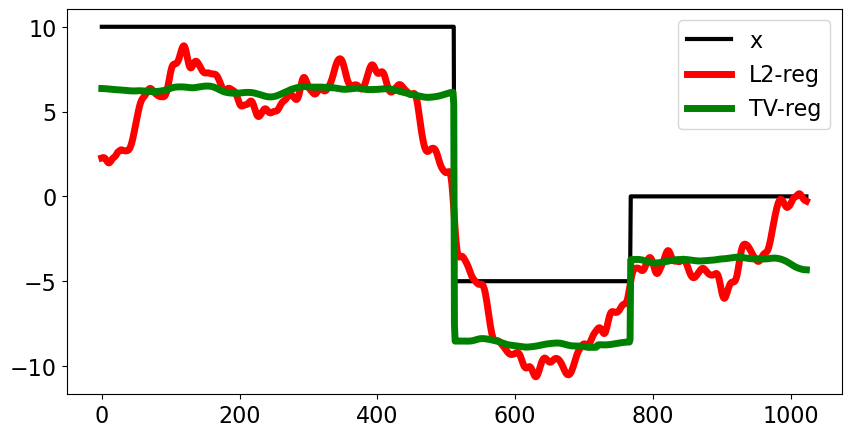

In [19]:
D2op = FirstDerivative(nt, edge=True, kind='backward', dtype=np.complex128)
F = pyproximal.L2(Rop @ FFTop, y, niter=20)
G = pyproximal.L1(3.)

L = (D2op.H @ D2op).eigs(1)[0].real
tau = 1.
mu = tau / L
xtv = pyproximal.optimization.primal.LinearizedADMM(F, G, D2op, np.zeros_like(x).astype(np.complex128),
                                                    tau, mu, niter=500, show=False)[0].real

#with plt.xkcd():
plt.figure(figsize=(10, 5))
plt.plot(x, "k", lw=3, label="x")
plt.plot(xinv, "r", lw=5, label="L2-reg")
plt.plot(xtv, "g", lw=5, label="TV-reg")
plt.legend();

## Recap

In this first tutorial we have learned to:

- perform the Fourier transform with a linear operator implementing the FFT (instead of a dense matrix implementing the DFT);
- use PyLops FFT linear operators to solve a simple optimization problem.